<a href="https://colab.research.google.com/github/abdipourasl/Deep-Learning-1402/blob/main/DL5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-block alert-success">
<h1>Deep Learning Project #5<h1>
Amin Abdipour 401133011</h1>
</div>

# Importing Libraries

In [336]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import os
import os.path as op
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')
from sklearn.preprocessing import MinMaxScaler

# import cv2
# from google.colab.patches import cv2_imshow
# from PIL import Image
# from torch.utils.data import random_split, DataLoader
# from sklearn.metrics import accuracy_score, confusion_matrix


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Predict With RNN (LSTM)

## 1. Load Data

We have ConnectTimeout error for this section, so Run this Section in VS Code and Load Excel data

In [337]:
# import pytse_client as tse
# tickers = tse.download(symbols=['فولاد'], write_to_csv=True, adjust=True , include_jdate=True)
# display(tickers['فولاد '])

# indices=tse.download_financial_indexes(symbols=['شاخص كل'],include_jdate=True,write_to_csv=True)
# display(indices['شاخص كل'])

# indices=tse.download_financial_indexes(symbols=['شاخص كل (هم وزن)'],include_jdate=True,write_to_csv=True)
# display(indices['شاخص كل (هم وزن)'])

In [338]:
dir = op.join('/content/drive/My Drive/','DL','DL_HW05','فولاد-ت.csv')  # Path to the Data folder
Foolad = pd.read_csv(dir)
dir = op.join('/content/drive/My Drive/','DL','DL_HW05','شاخص كل.csv')  # Path to the Data folder
All = pd.read_csv(dir)
dir = op.join('/content/drive/My Drive/','DL','DL_HW05','شاخص كل (هم وزن).csv')  # Path to the Data folder
HamVazn = pd.read_csv(dir)
Foolad

,date,open,high,low,adjClose,value,volume,count,yesterday,close,jdate
0,2007-03-11,9.0,10.0,9.0,9.0,889437216900,468077431,7736,9.0,9.0,1385-12-20
1,2007-03-12,10.0,10.0,10.0,10.0,193879458000,100041000,9214,9.0,10.0,1385-12-21
2,2007-03-13,10.0,10.0,9.0,10.0,249241504527,126270939,5862,10.0,10.0,1385-12-22
3,2007-03-14,10.0,10.0,10.0,10.0,51666379451,26705128,1901,10.0,10.0,1385-12-23
4,2007-03-17,9.0,10.0,9.0,9.0,28239006789,14877283,1514,10.0,9.0,1385-12-26
...,...,...,...,...,...,...,...,...,...,...,...
3715,2023-12-30,6280.0,6330.0,6250.0,6280.0,413007029830,65778615,3774,6220.0,6280.0,1402-10-09
3716,2023-12-31,6300.0,6300.0,6180.0,6230.0,498910921170,80066614,3884,6280.0,6190.0,1402-10-10
3717,2024-01-01,6230.0,6230.0,6150.0,6200.0,417831898480,67436187,3320,6230.0,6180.0,1402-10-11
3718,2024-01-02,6180.0,6220.0,6100.0,6160.0,446092828520,72415054,3753,6200.0,6150.0,1402-10-12


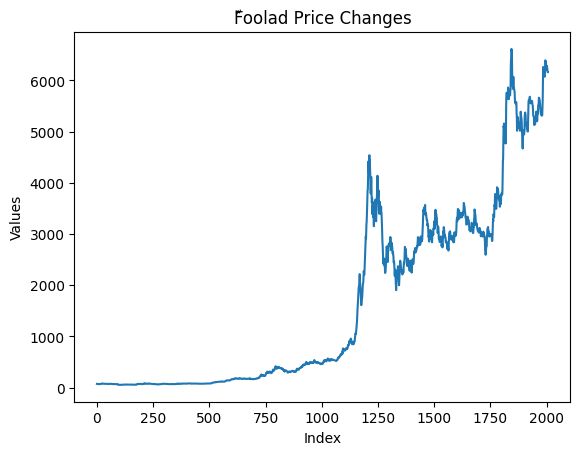

In [339]:
import numpy as np
import matplotlib.pyplot as plt


x_values = np.arange(len(merged_Foolad))

# Plotting the array
plt.plot(x_values, merged_Foolad)
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('ّFoolad Price Changes')
plt.show()


## 2. Merge 3 data with Common Dates

In [350]:
# Find the common dates
common_dates = np.intersect1d(np.intersect1d(Foolad['jdate'].values, All['jdate'].values), HamVazn['jdate'].values)

# Create empty matrices to store the merged data
merged_Foolad = np.zeros(len(common_dates))
merged_All = np.zeros(len(common_dates))
merged_HamVazn = np.zeros(len(common_dates))

# Find the indices of common dates in each matrix
indices_Foolad = np.where(np.isin(Foolad['jdate'].values, common_dates))[0]
indices_All = np.where(np.isin(All['jdate'].values, common_dates))[0]
indices_HamVazn = np.where(np.isin(HamVazn['jdate'].values, common_dates))[0]

mat1 = Foolad['adjClose'].values
mat2 = All['close'].values
mat3 = HamVazn['close'].values

merged_Foolad = mat1[indices_Foolad]
merged_All = mat2[indices_All]
merged_HamVazn = mat3[indices_HamVazn]

labels = np.zeros(2006)
labels = np.where(merged_Foolad[1:] >= merged_Foolad[:-1], 1, 0)


# concatenate them
data = np.vstack((merged_Foolad[1000:-1],merged_All[1000:-1],merged_HamVazn[1000:-1],common_dates[1000:-1],labels[1000:]))

print(data.shape)
data

(5, 1006)


array([[466.0, 465.0, 466.0, ..., 6230.0, 6200.0, 6160.0],
       [260992, 262941, 266127, ..., 2176102, 2168327, 2158766],
       [69321, 70466, 72125, ..., 758313, 757994, 755945],
       ['1398-05-27', '1398-05-28', '1398-05-30', ..., '1402-10-10',
        '1402-10-11', '1402-10-12'],
       [0, 1, 0, ..., 0, 0, 1]], dtype=object)


<h2>data[0,:] : Foolad<h2>
data[1,:] : Shakhese Kol <h2>
data[2,:] : Shakhese Ham Vazn <h2>
data[3,:] : Common Dates <h2>
data[4,:] : Labels <h2>


In [351]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

# Assuming your data is stored in a numpy array named 'data'
# Columns 0 to 2 are features, and column 3 is the label (increase or decrease)
# Replace 'your_data.npy' with the actual file name or provide the data accordingly

# Load and preprocess the data
# data = np.load('your_data.npy')
data = data.T
features = data[:, :3].astype(np.float64)  # Convert features to float64
labels = data[:, 4].astype(np.int64)  # Convert labels to int64 for classification

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
features = scaler.fit_transform(features)

# Create data windows
def create_windows(data, window_size):
    windows = []
    targets = []
    for i in range(len(data) - window_size):
        window = data[i:i+window_size, :3]  # Extract only the first 3 columns (features)
        target = data[i+window_size, -1]  # Extract the label from the last column
        windows.append(window)
        targets.append(target)
    return torch.tensor(windows), torch.tensor(targets, dtype=torch.long)  # Use dtype=torch.long for classification labels

window_size = 10  # Adjust as needed
X, y = create_windows(np.hstack((features, labels.reshape(-1, 1))), window_size)

# Split into training and testing sets
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Define the model, loss function, and optimizer
input_size = 3  # Since there are 3 features
hidden_size = 50  # Adjust as needed
output_size = 2  # Two classes: increase and decrease
model = RNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 50  # Adjust as needed
for epoch in range(num_epochs):
    outputs = model(X_train.float())
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

# Testing the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test.float())
    predicted_labels = torch.argmax(test_outputs, dim=1).numpy()

# Print or use 'predicted_labels' for further analysis
print(predicted_labels)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## 3. Normalize Features

In [341]:
features = data[:3, :].T.astype(np.float64)
labels = data[4, :].astype(np.)

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
features = scaler.fit_transform(features)

<ipython-input-341-a2a4fb5335df>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = data[4, :].astype(np.int)


## 4.Create data windows

In [342]:
def create_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size):
        window = data[i:i+window_size]
        windows.append(window)
    return torch.tensor(windows)


## 5. Split data and adjust window size

In [343]:
window_size = 2  # Adjust as needed
X = create_windows(features, window_size)
y = torch.tensor(labels[window_size-1:], dtype=torch.long)
# Split into training and testing sets
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


## 6. Define RNN Model

In [344]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


In [345]:
input_size = 3  # Since there are 3 features
hidden_size = 10  # Adjust as needed
output_size = 1  # Output 1 for increase, -1 for decrease
model = RNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 7. Training

In [346]:
from torch.utils.data import TensorDataset, DataLoader


# Create DataLoader
train_dataset = TensorDataset(X_train.float(), y_train.float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# # Training the model with DataLoader
for epoch in range(10):
    for inputs, targets in train_loader:
        outputs = model(inputs)
        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()



RuntimeError: ignored

## 8. Test

In [ ]:
# Testing the model
predicted_labels = []
model.eval()
with torch.no_grad():
    test_outputs = model(X_test.float())
    predicted_labels.append(np.sign(test_outputs.numpy()))
    print(test_outputs.numpy())

# Print or use 'predicted_labels' for further analysis
print(predicted_labels)

In [ ]:
from sklearn.metrics import confusion_matrix
a = np.array(*predicted_labels)
conf_matrix = confusion_matrix(y_test[1:], a)
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()